In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import sklearn 
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import sys

current_folder_path = os.path.abspath('')

## Loading the training dataset
The numpy array has the following shapes :
- 6556 rows, reprensenting 6556 event occurences
- 1445 columns representing :  
-- 1 column of step value (initialized for every serie id (ie test subject))  
-- 721 columns of **anglez** samples, centered 30 minutes before and after an event  
-- 721 columns of **enmo** samples, centered 30 minutes before and after an event  
-- 1 column of timestamp, ie the moment of the sample   
-- 1 column of **event** which is the **target** of the dataset. (0: *onset*, 1: *wakeup*)  

In [9]:
offset = 75
data = np.load(f"{current_folder_path}/training_data/data_{offset}.npy")

#[step, :, :, timestamp, event]
step = data[:,0]
X = data[:, 1:-2]
Y = data[:, -1]


## Data splitting

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

train_features = torch.from_numpy(X_train).float()
train_labels = torch.from_numpy(Y_train).float().unsqueeze(1)
test_features = torch.from_numpy(X_test).float()
test_labels = torch.from_numpy(Y_test).float().unsqueeze(1)

train_features = F.normalize(train_features)
test_features = F.normalize(test_features)

print(train_features.size(), train_labels.size(), test_features.size(), test_labels.size())

torch.Size([4922, 302]) torch.Size([4922, 1]) torch.Size([1641, 302]) torch.Size([1641, 1])


## NN architecture

In [4]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.input_size = input_size
        self.hidden_size= hidden_size
        self.output_size = output_size
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

        self.input_layer = nn.Linear(input_size, hidden_size)
        
        self.layer1 = nn.Linear(hidden_size, hidden_size//2)
        self.layer2 = nn.Linear(hidden_size//2, hidden_size//4)
        
        self.batchnorm1 = nn.BatchNorm1d(hidden_size//2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size//4)

        self.output_layer = nn.Linear(hidden_size//4, output_size)
        self.sigmoid = nn.Sigmoid()  
        self.dropout = nn.Dropout1d(p=0.1)
            
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        
        x = self.layer2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        x = self.output_layer(x)  
        #x = self.relu(x)    
        x = self.sigmoid(x)
        return x        



## Model training

In [7]:
m, n = train_features.shape
input_size = n
print(input_size)
hidden_size = 64
output_size = 1

model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimize = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

model.train() 
running_loss = 0.0

losses_list = []
num_epochs = int(input("Number of epochs : "))    
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    outputs = model(train_features)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    losses_list.append(loss.item())

print(f"Epoch {epoch+1}, Loss: {running_loss}")
#print(np.round(losses_list[::2], 6))


302


100%|██████████| 100/100 [00:02<00:00, 45.40it/s]

Epoch 100, Loss: 36.4848018437624
[0.692054 0.613406 0.581822 0.56611  0.550366 0.537596 0.527181 0.516066
 0.507576 0.49692  0.489183 0.477384 0.468741 0.454749 0.443663 0.434577
 0.42724  0.415307 0.405441 0.390693 0.381081 0.374509 0.361014 0.35064
 0.341655 0.333528 0.326484 0.318789 0.311143 0.301995 0.29551  0.29655
 0.280349 0.283262 0.269291 0.266737 0.262776 0.256771 0.254075 0.246094
 0.240596 0.237357 0.233156 0.23564  0.229335 0.225783 0.222448 0.215413
 0.217837 0.210995]


## Model testing

In [40]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    outputs = model(test_features) 
    print(outputs[0:10])
    #print(outputs[0:10].T)
    #predicted = torch.round(outputs.data)
    #_, predicted = torch.max(outputs.data, 1)
    predicted = torch.round(outputs.data)
    # predicted = np.round(outputs.numpy())
    total += test_labels.size(0)
    # correct += (predicted.numpy() == test_labels.numpy().T).sum().item()
    correct += (predicted == test_labels).sum().item()        
    
    #print(predicted.numpy()[0:10].T, test_labels.numpy().T[0, 0:10])
    #correct += (predicted == test_labels.numpy().T[0]).sum().item()
    print(total, correct)

    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")

tensor([[0.8394],
        [0.8583],
        [0.0280],
        [0.1735],
        [0.9717],
        [0.1020],
        [0.1466],
        [0.9406],
        [0.9755],
        [0.6050]])
1641 1504
Accuracy on test set: 91.65%


## Submission evaluation
#### Submission model eval

(450, 302)
(450, 300)
(450, 302)


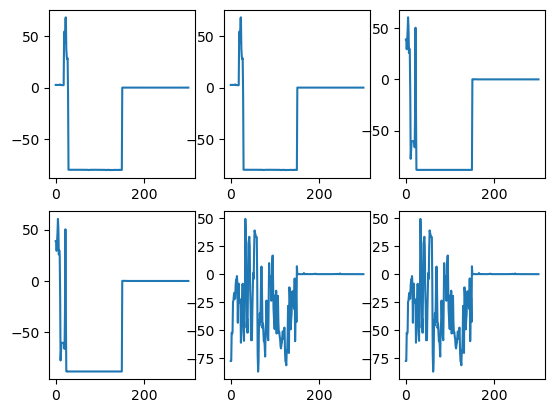

In [56]:
import matplotlib.pyplot as plt

data_sub = np.load(f"{current_folder_path}/submission.npy")
print(data_sub.shape)

#[step, :, :, timestamp]
step_sub = data_sub[:,0]
X_sub = data_sub[:, 1:-1]
print(X_sub.shape)

target_len = 302
padding_len = (target_len - X_sub.shape[1])//2
X_sub = np.pad(X_sub, padding_len, mode="edge")[padding_len:-padding_len, :]
print(X_sub.shape)

plt.subplots(2, 3)
for k in range(6):
    plt.subplot(2, 3, k+1)
    plt.plot(X_sub[k*75,:])


In [57]:
submission_features = torch.from_numpy(X_sub).float()

submission_features = F.normalize(submission_features)

print(submission_features.size())


torch.Size([450, 302])


(450, 1)
[0, '038441c925bb']
[[0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053]]
[0.052568890154361725] 0
[0.052568964660167694] 72
[2, '03d92c9f6f8a']
[[0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053]]
[0.052568890154361725] 0
[0.14496803283691406] 149
[4, '0402a003dae9']
[[0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053]]
[0.052568890154361725] 0
[0.14496803283691406] 148


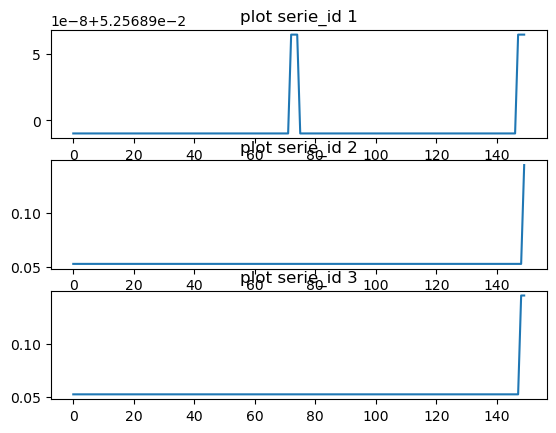

In [105]:
df_sample_submission = pd.read_csv(f"{current_folder_path}/sample_submission.csv")
columns=np.array([df_sample_submission.columns])
col = df_sample_submission.columns

arr_sample_submission = df_sample_submission.to_numpy()

model.eval()
with torch.no_grad():
    outputs = model(submission_features).numpy()

print(outputs.shape)
plt.subplots(3, 1)
len_test = outputs.shape[0]//150
for serie_id in range(len_test):
    answer_array_1 = []
    answer_array_2 = []

    # Row id 
    answer_array_1.append(serie_id*2)
    answer_array_2.append(serie_id*2+1)

    # series_id
    answer_array_1.append(df_sample_submission.iloc[serie_id*2, 1])
    answer_array_2.append(df_sample_submission.iloc[serie_id*2+1, 1])

    print(answer_array_1)

    current_serie = outputs.tolist()[serie_id:serie_id+150]
    print(np.round(current_serie[0:10], 3).T)
    score_onset, step_onset = min(current_serie), current_serie.index(min(current_serie))
    score_wakeup, step_wakeup = max(current_serie), current_serie.index(max(current_serie))

    print(score_onset, step_onset)
    print(score_wakeup, step_wakeup)

    plt.subplot(3, 1, serie_id+1)
    plt.plot(current_serie)
    plt.title(f"plot serie_id {serie_id+1}")

    # step
    answer_array_1.append(step_onset)
    answer_array_2.append(step_wakeup)

    # event
    answer_array_1.append(df_sample_submission.iloc[serie_id*2, 3])
    answer_array_2.append(df_sample_submission.iloc[serie_id*2+1, 3])

    # score
    answer_array_1.append(score_onset[0])
    answer_array_2.append(score_wakeup[0])

    # saving the submission
    arr_sample_submission[serie_id*2,:] = np.array(answer_array_1)
    arr_sample_submission[serie_id*2+1,:] = np.array(answer_array_2)

arr_sample_submission = np.concatenate([columns, arr_sample_submission], axis=0)
header = arr_sample_submission[0,:]
# Extract the data (excluding the header)
data = arr_sample_submission[1:,:]
# Create a Pandas DataFrame with the header
df = pd.DataFrame(data, columns=header)
df.to_csv(f"{current_folder_path}/submission.csv", index=False)
#np.savetxt(f"{current_folder_path}/anwer_sheet.txt", arr_sample_submission, delimiter=',')

#### Submission csv